# El dataset se puede descargar de: https://www.kaggle.com/datasets/imsparsh/musicnet-dataset

Una vez descargado se debe poner en la carpeta /kaggle/input/musicnet-dataset todo el contenido de la descarga

_______________________________

Para la ejecucipn de este cuaderno se deben instalar las siguientes librerias (en las versiones establecidas), tal como se muestra a continuacion

# 1) Preprocesar datos

In [1]:
import numpy as np

from libraries.Kaggle_audios import Kaggle_audios
from libraries.ProcessAudio import ProcessAudio

import pickle

In [2]:
TIEMPO_SELECCIONADO = 2
ARCHIVO_FINAL_TRAIN = "data/scaler_pca_to_use/train"
ARCHIVO_FINAL_TEST = "data/scaler_pca_to_use/test"

In [14]:
from functools import wraps
from time import time


def count_elapsed_time(f):
    @wraps(f)
    def cronometro(*args, **kwargs):
        t_inicial = time()  # tomo la hora antes de ejecutar la funcion
        salida = f(*args, **kwargs)
        t_final = time()  # tomo la hora despues de ejecutar la funcion
        print('Tiempo transcurrido (en segundos): {}'.format(t_final - t_inicial))
        return salida

    return cronometro

In [3]:
def prepare_data_tensorflow(data):
    train = data[:, 1:-11]
    instrument_list = data[:,-11:]
    X = np.array(train, dtype=float)
    y = instrument_list
    return X, y

def aplicando_pca(scaler_pca, name_file, dataX, dataY):
    x_for_model = scaler_pca.transform(X=dataX)
    # print("Original", X.shape)
    np.savez_compressed(name_file + ".npz", data=x_for_model)
    np.savez_compressed(name_file + "_label.npz", data=dataY)
    
def leyendo_datos(name_file):
    x = np.load(name_file + ".npz")['data']
    y = np.load(name_file + "_label.npz")['data']
    return x, y

def Preprocesar_audios(name_file, use_train, save:bool = True):
    cortar = Kaggle_audios(config_time=TIEMPO_SELECCIONADO, train=use_train)

    print("\tLeyendo todos los archivos WAV originales")
    all_data, all_label, rate = cortar.read_data(
        limit=None, show_info=False)  # leer todos los wav y cada uno separarlos en pequeños audios de 3 segundos

    print("\tTime:", TIEMPO_SELECCIONADO, " - Input:", all_data.shape, " - Output:", all_label.shape, " - rate:", rate)

    print("\tExtrayendo caracteristicas audios")
    data = list()
    for id_audio, x in enumerate(all_data):
        processAudio = ProcessAudio()
        processAudio.set_data(x)
        data_save = processAudio.get_all(id_audio)  # Extrayendo caracteristicas audios, salen 26 caracteristicas
        data_save += all_label[id_audio].tolist()

        data.append(data_save)
        try:
            if id_audio%150 == 0:
                print("\n\t", end="")
            print(".", end="")
        except:
            print()

    print("\tConvirtiendo a numpy")
    data = np.array(data)

    if save:
        print("\tGuardando data")
        np.savez_compressed(name_file + '.npz', data)
        print("\tGuardando csv completo")

    return data

## 1.1) Leer audios, separarlos en audios mas pequeños y extraer las caracteristicas de cada uno de estos nuevos audios

In [ ]:
print("Preprocesando TRAIN")
data_train = Preprocesar_audios(ARCHIVO_FINAL_TRAIN, use_train=True, save=False)
print("\tTime:", TIEMPO_SELECCIONADO, " - Train:", len(data_train))

## 1.2) Hallando el normalizador y el PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [ ]:
X_train, _ = prepare_data_tensorflow(data_train)
scaler_pca = make_pipeline(StandardScaler(), PCA())
scaler_pca.fit(X_train)

modelo_pca = scaler_pca.named_steps['pca']

In [ ]:
import matplotlib.pyplot as plt
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
ax.plot(
    np.arange(26) + 1,
    prop_varianza_acum,
    marker='o'
)

for x, y in zip(np.arange(26) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=20
    )

ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')

ax.axvline(x=15, color="red")
ax.axhline(y=0.925, color="red")

plt.show()


In [ ]:
"""
            Hallando el Normalizador y el PCA (92%)
"""

MINIMA_VARIANA_EXPLICADA = 0.92
scaler_pca = make_pipeline(StandardScaler(), PCA(MINIMA_VARIANA_EXPLICADA))
scaler_pca.fit(X_train)

In [19]:
pickle.dump(scaler_pca, open('data/scaler_pca_to_use/scaler_pca.pkl','wb'))

NameError: name 'scaler_pca' is not defined

## 1.3) Aplicando el normalizador, PCA a los datos train y guardando el resultado

In [ ]:
"""
            Aplicando PCA
"""
X_train, Y_train = prepare_data_tensorflow(data_train)
aplicando_pca(scaler_pca, ARCHIVO_FINAL_TRAIN, X_train, Y_train )

## 1.4) Aplicando el normalizador, PCA a los datos test y guardando el resultado

In [ ]:
print("Preprocesando TEST")
data_test = Preprocesar_audios(ARCHIVO_FINAL_TEST, False, save=False)
print("\tTime:", TIEMPO_SELECCIONADO, " - Test:", len(data_test))

X_test, Y_test = prepare_data_tensorflow(data_test)
aplicando_pca(scaler_pca, ARCHIVO_FINAL_TEST, X_test, Y_test )

# 2) Cargando los datos para usarlos en el entrenamiento del modelo

In [4]:
"""
            Leyendo datos
"""
xTrain_for_model_charge, yTrain = leyendo_datos(ARCHIVO_FINAL_TRAIN)
print("x_for_model_charge_train:", xTrain_for_model_charge.shape, yTrain.shape)

x_for_model_charge_train: (60851, 15) (60851, 11)


In [25]:
xTest_for_model_charge, yTest = leyendo_datos(ARCHIVO_FINAL_TEST)
print("x_for_model_charge_test:", xTest_for_model_charge.shape, yTest.shape)

x_for_model_charge_test: (745, 15) (745, 11)


# 3) Creando y entrenando modelos modelos

## 3.1) Modelo clasico

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

In [27]:
mean = lambda lst: int((sum(lst) / len(lst))*100)/100


def calcular_porcentajes_aciertos(y_f, y_t):
    verdaderos = dict()
    falsos = dict()
    for j in range(y_f.shape[1]):
        verdaderos[j] = 0
        falsos[j] = 0

    for i in range(y_f.shape[0]):
        for j in range(y_f.shape[1]):
            if y_f[i][j] == y_t[i][j]:
                verdaderos[j] += 1
            else:
                falsos[j] += 1

    for j in range(y_f.shape[1]):
        #y_final.shape[1] -> 100%
        #verdaderos[j]    -> X
        verdaderos[j] = int(verdaderos[j] * 100 / y_f.shape[0])
        falsos[j] = int(falsos[j] * 100 / y_f.shape[0])

    return verdaderos, falsos, str(mean([v for i, v in verdaderos.items()])) + "%"

## 3.1.1)  Dividiendo datos para train y valid

In [9]:
X_train, X_test, y_train, y_test = train_test_split(xTrain_for_model_charge, yTrain, test_size=0.1)  # 0.2

## 3.2) Entrenando modelo

In [11]:
algoritmo_clasico = RandomForestClassifier()
algoritmo_clasico = MultiOutputClassifier(algoritmo_clasico, n_jobs=-1)

seed = 1
grid = GridSearchCV(
          estimator = algoritmo_clasico,
          param_grid={},
          cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        )
grid.fit(X_train, y_train)
algoritmo_clasico = grid.best_estimator_




y_final = algoritmo_clasico.predict(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("[RandomForestClassifier] Aciertos train", aciertos)





y_final = algoritmo_clasico.predict(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("[RandomForestClassifier] Aciertos validacion", aciertos)





y_final = algoritmo_clasico.predict(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("[RandomForestClassifier] Aciertos test", aciertos)

[RandomForestClassifier] Aciertos train 99.81%
[RandomForestClassifier] Aciertos validacion 95.72%
[RandomForestClassifier] Aciertos test 94.63%


In [12]:
algoritmo_clasico = LogisticRegression(
          solver='sag', #'liblinear', 'sag'
          max_iter=1000, 
          random_state=1, #0 ,1
          multi_class='ovr'
          )
algoritmo_clasico = MultiOutputClassifier(algoritmo_clasico, n_jobs=-1)

seed = 1
grid = GridSearchCV(
          estimator = algoritmo_clasico,
          param_grid={},
          cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        )
grid.fit(X_train, y_train)
algoritmo_clasico = grid.best_estimator_



y_final = algoritmo_clasico.predict(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("[LogisticRegression] Aciertos train", aciertos)




y_final = algoritmo_clasico.predict(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("[LogisticRegression] Aciertos validacion", aciertos)





y_final = algoritmo_clasico.predict(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("[LogisticRegression] Aciertos test", aciertos)

[LogisticRegression] Aciertos train 92.18%
[LogisticRegression] Aciertos validacion 92.36%
[LogisticRegression] Aciertos test 90.72%


In [13]:
algoritmo_clasico = DecisionTreeClassifier(
          max_depth = None,
          min_samples_split = 2,
          min_samples_leaf  = 1,
          random_state      = 123
          )
algoritmo_clasico = MultiOutputClassifier(algoritmo_clasico, n_jobs=-1)

seed = 1
grid = GridSearchCV(
          estimator = algoritmo_clasico,
          param_grid={},
          cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        )
grid.fit(X_train, y_train)
algoritmo_clasico = grid.best_estimator_



y_final = algoritmo_clasico.predict(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("[DecisionTreeClassifier] Aciertos train", aciertos)





y_final = algoritmo_clasico.predict(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("[DecisionTreeClassifier] Aciertos validacion", aciertos)





y_final = algoritmo_clasico.predict(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("[DecisionTreeClassifier] Aciertos test", aciertos)

[DecisionTreeClassifier] Aciertos train 100.0%
[DecisionTreeClassifier] Aciertos validacion 92.54%
[DecisionTreeClassifier] Aciertos test 91.45%


In [14]:
algoritmo_clasico = DummyClassifier()
algoritmo_clasico = MultiOutputClassifier(algoritmo_clasico, n_jobs=-1)

seed = 1
grid = GridSearchCV(
          estimator = algoritmo_clasico,
          param_grid={},
          cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        )
grid.fit(X_train, y_train)
algoritmo_clasico = grid.best_estimator_



y_final = algoritmo_clasico.predict(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("[DummyClassifier] Aciertos train", aciertos)





y_final = algoritmo_clasico.predict(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("[DummyClassifier] Aciertos validacion", aciertos)





y_final = algoritmo_clasico.predict(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("[DummyClassifier] Aciertos test", aciertos)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/usr/

[DummyClassifier] Aciertos train 85.54%
[DummyClassifier] Aciertos validacion 85.63%
[DummyClassifier] Aciertos test 81.54%


In [17]:
algoritmo_clasico = KNeighborsClassifier(11)
algoritmo_clasico = MultiOutputClassifier(algoritmo_clasico, n_jobs=-1)

seed = 1
grid = GridSearchCV(
          estimator = algoritmo_clasico,
          param_grid={},
          cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        )
grid.fit(X_train, y_train)
algoritmo_clasico = grid.best_estimator_



y_final = algoritmo_clasico.predict(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("[KNeighborsClassifier] Aciertos train", aciertos)





y_final = algoritmo_clasico.predict(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("[KNeighborsClassifier] Aciertos validacion", aciertos)





y_final = algoritmo_clasico.predict(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("[KNeighborsClassifier] Aciertos test", aciertos)

[KNeighborsClassifier] Aciertos train 96.81%
[KNeighborsClassifier] Aciertos validacion 96.18%
[KNeighborsClassifier] Aciertos test 96.0%


In [16]:
algoritmo_clasico = GaussianNB()
algoritmo_clasico = MultiOutputClassifier(algoritmo_clasico, n_jobs=-1)

seed = 1
grid = GridSearchCV(
          estimator = algoritmo_clasico,
          param_grid={},
          cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        )
grid.fit(X_train, y_train)
algoritmo_clasico = grid.best_estimator_



y_final = algoritmo_clasico.predict(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("[GaussianNB] Aciertos train", aciertos)





y_final = algoritmo_clasico.predict(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("[GaussianNB] Aciertos validacion", aciertos)





y_final = algoritmo_clasico.predict(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("[GaussianNB] Aciertos test", aciertos)

[GaussianNB] Aciertos train 90.63%
[GaussianNB] Aciertos validacion 90.81%
[GaussianNB] Aciertos test 89.0%


## 3.3) Guardando modelo

In [21]:
pickle.dump(algoritmo_clasico, open('data/scaler_pca_to_use/KNeighborsClassifier.pkl', 'wb'))

## 3.4) Cargando modelo

In [36]:
#model = pickle.load(open('data/scaler_pca_to_use/KNeighborsClassifier.pkl', 'rb'))
model = pickle.load(open('data/scaler_pca_to_use/randomforest.pkl', 'rb'))

## 3.5) Probando modelo

In [17]:
y_final = model.predict(X_train)

aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("Aciertos train", aciertos)

Aciertos train 96.63%


## 3.3) Validando modelo

In [18]:
y_final = model.predict(X_test)

aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("Aciertos validacion", aciertos)

Aciertos validacion 96.72%


## 3.4) Testeando modelo

In [37]:
@count_elapsed_time
def predecir():
    y_final = model.predict(xTest_for_model_charge)
    return y_final

y_final = predecir()
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("Aciertos test", aciertos)

Tiempo transcurrido (en segundos): 0.8689899444580078
Aciertos test 94.9%


# 4) Creando y entrenando modelo red neuronal

In [38]:
xTrain_for_model_charge, yTrain = leyendo_datos(ARCHIVO_FINAL_TRAIN)
yTrain = np.array(yTrain, dtype=float)
xTrain_for_model_charge = np.array(xTrain_for_model_charge, dtype=float)
print("datos train:", xTrain_for_model_charge.shape, yTrain.shape)

xTest_for_model_charge, yTest = leyendo_datos(ARCHIVO_FINAL_TEST)
yTest = np.array(yTest, dtype=float)
xTest_for_model_charge = np.array(xTest_for_model_charge, dtype=float)
print("datos test:", xTest_for_model_charge.shape, yTest.shape)

datos train: (60851, 15) (60851, 11)
datos test: (745, 15) (745, 11)


In [39]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, LeakyReLU, Conv1D, Conv2D, Flatten, MaxPooling2D, Input
from tensorflow.keras.layers import BatchNormalization, InputLayer, Reshape, Activation, GlobalAveragePooling1D
from tensorflow.keras.layers import AveragePooling2D, AveragePooling1D, UpSampling1D, UpSampling2D, MaxPooling1D

In [40]:
from tensorflow.keras.optimizers import Adam
def get_optimizador():
    adam = Adam(learning_rate=1e-5)
    return adam

In [41]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, RemoteMonitor, TerminateOnNaN, BackupAndRestore

def get_callbacks(name="model"):
    #EarlyStopping, detener el entrenamiento una vez que su pérdida comienza a aumentar
    early_stop = EarlyStopping(
        monitor='accuracy',
        patience=8, #argumento de patience representa el número de épocas antes de detenerse una vez que su pérdida comienza a aumentar (deja de mejorar).
        min_delta=0,  #es un umbral para cuantificar una pérdida en alguna época como mejora o no. Si la diferencia de pérdida es inferior a min_delta , se cuantifica como no mejora. Es mejor dejarlo como 0 ya que estamos interesados ​​en cuando la pérdida empeora.
        restore_best_weights=True,
        mode='max')

    #ReduceLROnPlateau, que si el entrenamiento no mejora tras unos epochs específicos, reduce el valor de learning rate del modelo
    reduce_lr = ReduceLROnPlateau(
        monitor='loss', 
        factor=0.1, 
        patience=5, 
        min_delta=1e-4, 
        mode='min',
        verbose=1,
    )

    # Saves Keras model after each epoch
    #Para algunos casos es importante saber cual entrenamiento fue mejor, 
    #este callback guarda el modelo tras cada epoca completada con el fin de si luego se desea un registro de pesos para cada epoca
    #Se ha usado este callback para poder optener el mejor modelo de pesos, sobretodo en la red neuronal creada desde cero
    #siendo de gran utilidad para determinar el como ir modificando los layer hasta obtener el mejor modelo
    checkpointer = ModelCheckpoint(
        filepath='models_backup/' + name +'-{val_accuracy:.4f}.h5', 
        monitor='val_accuracy',
        verbose=1, 
        mode='max',
        save_best_only=True,
        save_weights_only=False
    )

    remote_monitor = RemoteMonitor(
        root='http://localhost:6006',
        path='/publish/epoch/end/',
        field='data',
        headers=None,
        send_as_json=False
    )
    
    backup_restore = BackupAndRestore(backup_dir="backup")
    
    proteccion_nan_loss = TerminateOnNaN()

    
    callbacks_list = [early_stop, reduce_lr, checkpointer, proteccion_nan_loss, backup_restore]#, remote_monitor]
    
    return callbacks_list

In [42]:
import matplotlib.pyplot as plt
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## 4.1) Modelo basico

In [43]:
cantidad_entradas = 15
cantidad_salidas = 11

model = Sequential(name="RedBasica")
model.add(Dense(32, activation='relu', input_shape=(cantidad_entradas,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(cantidad_salidas, activation='softmax', name='output_layer'))

model.summary()

Model: "RedBasica"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 256)               16640     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0 

In [44]:
model.compile(optimizer=get_optimizador(),
              loss='mse',  # categorical_crossentropy sparse_categorical_crossentropy mean_squared_error
              metrics=['accuracy'])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(xTrain_for_model_charge, yTrain, test_size=0.1)  # 0.2

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=64,
    verbose=1,
    callbacks=get_callbacks()
)

Epoch 1/500
846/856 [============================>.] - ETA: 0s - loss: 0.1295 - accuracy: 0.5648
Epoch 1: val_accuracy improved from -inf to 0.76076, saving model to models_backup/model-0.7608.h5
856/856 [==============================] - 3s 3ms/step - loss: 0.1294 - accuracy: 0.5661 - val_loss: 0.1048 - val_accuracy: 0.7608 - lr: 1.0000e-05
Epoch 2/500
844/856 [============================>.] - ETA: 0s - loss: 0.1028 - accuracy: 0.7205
Epoch 2: val_accuracy improved from 0.76076 to 0.76503, saving model to models_backup/model-0.7650.h5
856/856 [==============================] - 2s 2ms/step - loss: 0.1027 - accuracy: 0.7205 - val_loss: 0.0908 - val_accuracy: 0.7650 - lr: 1.0000e-05
Epoch 3/500
840/856 [============================>.] - ETA: 0s - loss: 0.0954 - accuracy: 0.7111
Epoch 3: val_accuracy improved from 0.76503 to 0.76881, saving model to models_backup/model-0.7688.h5
856/856 [==============================] - 2s 2ms/step - loss: 0.0954 - accuracy: 0.7113 - val_loss: 0.0872 - 

Epoch 27/500
850/856 [============================>.] - ETA: 0s - loss: 0.0771 - accuracy: 0.7489
Epoch 27: val_accuracy improved from 0.79790 to 0.80891, saving model to models_backup/model-0.8089.h5
856/856 [==============================] - 2s 2ms/step - loss: 0.0770 - accuracy: 0.7493 - val_loss: 0.0739 - val_accuracy: 0.8089 - lr: 1.0000e-05
Epoch 28/500
836/856 [============================>.] - ETA: 0s - loss: 0.0767 - accuracy: 0.7540
Epoch 28: val_accuracy did not improve from 0.80891
856/856 [==============================] - 2s 2ms/step - loss: 0.0767 - accuracy: 0.7535 - val_loss: 0.0738 - val_accuracy: 0.7864 - lr: 1.0000e-05
Epoch 29/500
855/856 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.7526
Epoch 29: val_accuracy did not improve from 0.80891
856/856 [==============================] - 2s 2ms/step - loss: 0.0766 - accuracy: 0.7525 - val_loss: 0.0736 - val_accuracy: 0.7882 - lr: 1.0000e-05
Epoch 30/500
849/856 [============================>.] -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


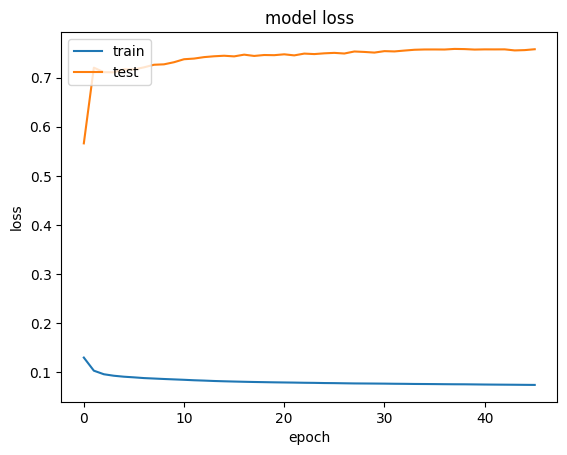

In [46]:
plot_history(history)

In [47]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Evaluate train acc: ', test_acc)

191/191 [==============================] - 0s 1ms/step - loss: 0.0721 - accuracy: 0.8055
Evaluate train acc:  0.8054551482200623


In [63]:
@count_elapsed_time
def predecir(d):
    y_final = model.predict(d)
    y_final = np.round(y_final, 0).astype(int)
    return y_final

In [64]:
y_final = predecir(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("Aciertos train", aciertos)

Tiempo transcurrido (en segundos): 1.2986009120941162
Aciertos train 90.36%


In [65]:
y_final = predecir(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("Aciertos validacion", aciertos)

Tiempo transcurrido (en segundos): 0.17863035202026367
Aciertos validacion 90.27%


In [66]:
y_final = predecir(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("Aciertos test", aciertos)

Tiempo transcurrido (en segundos): 0.06654071807861328
Aciertos test 90.09%


# 4.2) Modelo RNA medio

In [85]:
def modelo_simple(cantidad_entradas, cantidad_salidas):
    model = Sequential(name="Redsimple")  # los nombres van sin espacios
    model.add(Dense(8 * 4, activation="relu",  input_shape=(cantidad_entradas,)) ) 
    model.add(Dense(16*4, activation='relu'))
    model.add(Dense(16*8, activation='relu'))
    model.add(Dense(32*8, activation='relu'))
    model.add(Reshape((32, 8)))

    model.add(UpSampling1D(size=3))
    model.add(Conv1D(12, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(12, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(12, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=1, padding='valid'))

    model.add(Conv1D(24, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(24, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(32, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='valid'))

    model.add(Conv1D(32, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(32, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=1, padding='valid'))

    model.add(Conv1D(24, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(24, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(16, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=1, padding='valid'))

    model.add(Conv1D(16, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(8, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='valid'))

    model.add(Dense(24, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='valid'))

    model.add(Dropout(0.5))

    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(32, activation='relu'))

    model.add(GlobalAveragePooling1D())

    model.add(Flatten())

    model.add(Dense(cantidad_salidas, activation="softmax", name='output_layer'))

    return model

In [86]:
cantidad_entradas = 15
cantidad_salidas = 11

model = modelo_simple(cantidad_entradas, cantidad_salidas)

model.summary()

Model: "Redsimple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 32)                512       
                                                                 
 dense_20 (Dense)            (None, 64)                2112      
                                                                 
 dense_21 (Dense)            (None, 128)               8320      
                                                                 
 dense_22 (Dense)            (None, 256)               33024     
                                                                 
 reshape_2 (Reshape)         (None, 32, 8)             0         
                                                                 
 up_sampling1d_2 (UpSampling  (None, 96, 8)            0         
 1D)                                                             
                                                         

In [87]:
model.compile(optimizer=get_optimizador(),
              loss='mean_squared_error',  # categorical_crossentropy sparse_categorical_crossentropy mean_squared_error
              metrics=['accuracy'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xTrain_for_model_charge, yTrain, test_size=0.1)  # 0.2

In [94]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=64,
    verbose=1,
    callbacks=get_callbacks()
)



Epoch 1/500
851/856 [============================>.] - ETA: 0s - loss: 0.0852 - accuracy: 0.7797
Epoch 1: val_accuracy improved from -inf to 0.24121, saving model to models_backup/model-0.2412.h5
856/856 [==============================] - 9s 10ms/step - loss: 0.0852 - accuracy: 0.7800 - val_loss: 0.1434 - val_accuracy: 0.2412 - lr: 1.0000e-05
Epoch 2/500
852/856 [============================>.] - ETA: 0s - loss: 0.0839 - accuracy: 0.7758
Epoch 2: val_accuracy did not improve from 0.24121
856/856 [==============================] - 9s 10ms/step - loss: 0.0840 - accuracy: 0.7758 - val_loss: 0.1443 - val_accuracy: 0.2412 - lr: 1.0000e-05
Epoch 3/500
855/856 [============================>.] - ETA: 0s - loss: 0.0831 - accuracy: 0.7745
Epoch 3: val_accuracy did not improve from 0.24121
856/856 [==============================] - 8s 10ms/step - loss: 0.0831 - accuracy: 0.7745 - val_loss: 0.1459 - val_accuracy: 0.2412 - lr: 1.0000e-05
Epoch 4/500
856/856 [==============================] - ETA: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


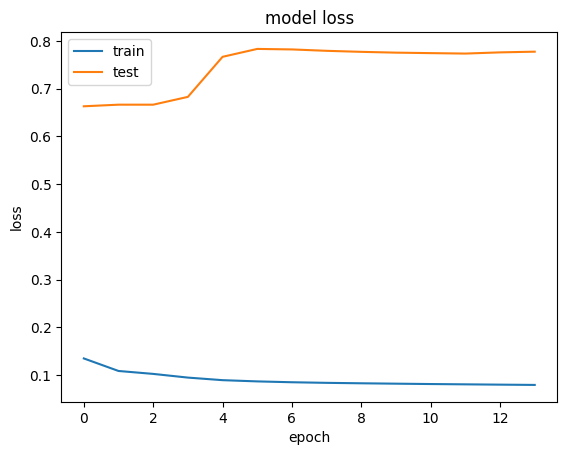

In [89]:
plot_history(history)

In [90]:
#test_loss, test_acc = model.evaluate(X_test, y_test)
#print('Evaluate train acc: ', test_acc)

In [91]:
y_final = predecir(X_train)
aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("Aciertos train", aciertos)

Tiempo transcurrido (en segundos): 6.672495365142822
Aciertos train 78.63%


In [92]:
y_final = predecir(X_test)
aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("Aciertos validacion", aciertos)

Tiempo transcurrido (en segundos): 0.6445150375366211
Aciertos validacion 78.72%


In [93]:
y_final = predecir(xTest_for_model_charge)
aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("Aciertos test", aciertos)

Tiempo transcurrido (en segundos): 0.33283400535583496
Aciertos test 80.09%


# Bibliografia usada